In [16]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

pd.reset_option('display.max_rows')


# Importing the dataset
X_dataset = pd.read_csv('dataset_interval_three.csv')

In [17]:

X_dataset = X_dataset.drop(['Unnamed: 0', 'subject_eyeD', 'subject_id', 'eye', 'number _visits',
       'dob', 'visit_date', 'baseline_visit', 'days_from_baseline', 'visit_number'], axis = 1)

In [18]:
print(X_dataset['primary_dx'].value_counts())
print(X_dataset['gender'].value_counts())
print(X_dataset['race'].value_counts())

GL     6822
GS     2853
PDS      39
Name: primary_dx, dtype: int64
female    5631
male      4083
Name: gender, dtype: int64
white    7386
black    1854
asian     474
Name: race, dtype: int64


In [19]:
X_dataset.head()

,primary_dx,gender,race,avg_cd_ratio,gca_average,gca_tempsup,gca_sup,gca_nassup,gca_nasinf,gca_inf,...,rnfl_nassup,rnfl_nasinf,rnfl_inf,rnfl_tempinf,md,p_md,psd,p_psd,vfi,age
0,GL,male,white,0.70,66,63,61,65,71,69,...,28,35,29,20,0.372392,5,2.041738,3,94.0,64.0
1,GL,male,white,0.69,66,64,61,65,71,68,...,28,35,29,20,0.457088,3,2.588213,5,94.0,65.0
2,GL,male,white,0.72,65,63,59,65,73,67,...,25,31,28,19,0.582103,2,1.905461,3,96.0,66.0
3,GL,male,white,0.69,66,64,61,65,71,68,...,28,35,29,20,0.457088,3,2.588213,5,94.0,65.0
4,GL,male,white,0.72,65,63,59,65,73,67,...,25,31,28,19,0.582103,2,1.905461,3,96.0,66.0


In [20]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, StandardScaler

#label encoding dx: 3 total
labelencoder_X_1 = LabelEncoder()
X_dataset.iloc[:, 0] = labelencoder_X_1.fit_transform(X_dataset.iloc[:, 0])

#label encoding gender: 2 total
labelencoder_X_2 = LabelEncoder()
X_dataset.iloc[:, 1] = labelencoder_X_2.fit_transform(X_dataset.iloc[:, 1])

#label encoding race: 3 total
labelencoder_X_3 = LabelEncoder()
X_dataset.iloc[:, 2] = labelencoder_X_3.fit_transform(X_dataset.iloc[:, 2])

X_dataset = pd.get_dummies(X_dataset, columns=['primary_dx', 'race'], drop_first=True)


In [21]:
X = []
y_VFI = []
y_MD = []
y_RNFL = []
y_GCA = []

for i in range(0, len(X_dataset)-2, 3):
    patient = []
    #drop variables
    patient.append(X_dataset.iloc[i,:].tolist())
    patient.append(X_dataset.iloc[i+1,:].tolist())
#     patient.append(X_dataset.iloc[i+2,:].tolist())
    y_VFI.append(X_dataset.loc[i+2,'vfi'].tolist())
    y_MD.append(X_dataset.loc[i+2,'md'].tolist())
    y_RNFL.append(X_dataset.loc[i+2,'rnfl_average'].tolist())
    y_GCA.append(X_dataset.loc[i+2,'gca_average'].tolist())
    X.append(patient)

In [22]:
X = np.array(X)
y_MD = np.array(y_MD)
y_GCA = np.array(y_GCA)
y_VFI = np.array(y_VFI)
y_RNFL = np.array(y_RNFL)
X.shape


(3238, 2, 26)

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Masking, BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

def lstm_baseline(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 200)
    
    batch_size=10
    model = Sequential()
    model.add(Masking(mask_value=9999.0))
    model.add(BatchNormalization(axis = 1))
    model.add(LSTM(128,
                   return_sequences=True,
                  ))

    model.add(LSTM(64))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    
    #compile model
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_absolute_error'])

#     model.fit(X_train,y_train, epochs= 500)

    weight_path="LSTM_Interval_best_{}.hdf5".format(name)
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list = [checkpoint, early_stop]
        
    #fit the model
    history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), shuffle=False, callbacks=callbacks_list, verbose=1)
    
    # plot train and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('loss_plot_{}.png'.format(name))
    plt.show()
    
    
    model.load_weights(weight_path)
    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    y_pred = y_pred.tolist()
    dictionary_DF = {'predicted':y_pred, 'actual':y_test}
    data = pd.DataFrame(dictionary_DF)
    data.to_csv('Predicted_vs_Actual_of_{}'.format(name))
    
    mean_absolute_error = abs(data['predicted']-data['actual'])
    mean_absolute_error = mean_absolute_error.describe()
    mean_absolute_error.to_csv('MAE_of_{}_Predicted_vs_Actual'.format(name))
    
    return model

# history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Train on 2072 samples, validate on 518 samples
Epoch 1/500
2072/2072 [==============================] - 3s 1ms/step - loss: 4374.9290 - mean_absolute_error: 64.2297 - val_loss: 2539.5801 - val_mean_absolute_error: 48.7762

Epoch 00001: val_loss improved from inf to 2539.58012, saving model to LSTM_Interval_best_RNFL.hdf5
Epoch 2/500
2072/2072 [==============================] - 1s 265us/step - loss: 1475.7014 - mean_absolute_error: 34.7664 - val_loss: 551.9966 - val_mean_absolute_error: 20.3195

Epoch 00002: val_loss improved from 2539.58012 to 551.99663, saving model to LSTM_Interval_best_RNFL.hdf5
Epoch 3/500
2072/2072 [==============================] - 1s 268us/step - loss: 378.0567 - mean_absolute_error: 15.6811 - val_loss: 171.7902 - val_mean_absolute_error: 10.3993

Epoch 00003: val_loss improved from 551.99663 to 171.79024, saving model to LSTM_Interval_best_RNFL.hdf5
Epoch 4/500
2072/2072 [==============================] - 1s 284us/step - loss: 271.5747 - mean_absolute_error: 13

2072/2072 [==============================] - 1s 294us/step - loss: 111.7508 - mean_absolute_error: 8.2988 - val_loss: 10.9346 - val_mean_absolute_error: 2.5125

Epoch 00033: val_loss did not improve from 9.33394
Epoch 34/500
2072/2072 [==============================] - 1s 278us/step - loss: 105.2991 - mean_absolute_error: 7.9527 - val_loss: 10.9594 - val_mean_absolute_error: 2.4474

Epoch 00034: val_loss did not improve from 9.33394
Epoch 35/500
2072/2072 [==============================] - 1s 260us/step - loss: 114.9730 - mean_absolute_error: 8.4297 - val_loss: 18.3637 - val_mean_absolute_error: 3.4008

Epoch 00035: val_loss did not improve from 9.33394
Epoch 36/500
2072/2072 [==============================] - 1s 275us/step - loss: 109.2856 - mean_absolute_error: 8.2812 - val_loss: 9.3292 - val_mean_absolute_error: 2.2995

Epoch 00036: val_loss improved from 9.33394 to 9.32919, saving model to LSTM_Interval_best_RNFL.hdf5
Epoch 37/500
2072/2072 [==============================] - 1s 256

2072/2072 [==============================] - 1s 286us/step - loss: 104.9797 - mean_absolute_error: 8.0023 - val_loss: 13.0348 - val_mean_absolute_error: 2.8214

Epoch 00069: val_loss did not improve from 8.34193
Epoch 70/500
2072/2072 [==============================] - 1s 277us/step - loss: 104.1028 - mean_absolute_error: 8.0891 - val_loss: 8.5208 - val_mean_absolute_error: 2.1552

Epoch 00070: val_loss did not improve from 8.34193
Epoch 71/500
2072/2072 [==============================] - 1s 287us/step - loss: 107.1674 - mean_absolute_error: 8.0091 - val_loss: 10.1985 - val_mean_absolute_error: 2.3819

Epoch 00071: val_loss did not improve from 8.34193
Epoch 72/500
2072/2072 [==============================] - 1s 277us/step - loss: 104.6715 - mean_absolute_error: 8.0653 - val_loss: 13.2092 - val_mean_absolute_error: 2.8215

Epoch 00072: val_loss did not improve from 8.34193
Epoch 73/500
2072/2072 [==============================] - 1s 284us/step - loss: 108.0530 - mean_absolute_error: 8.

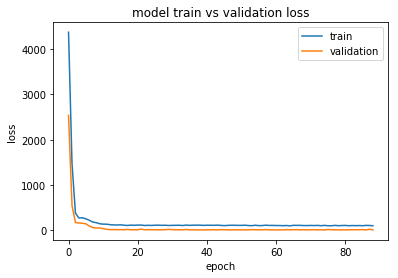

In [28]:
lstm_baseline(X, y_RNFL, 'RNFL')

Train on 2072 samples, validate on 518 samples
Epoch 1/500
2072/2072 [==============================] - 3s 2ms/step - loss: 0.1509 - mean_absolute_error: 0.3048 - val_loss: 0.0843 - val_mean_absolute_error: 0.2204

Epoch 00001: val_loss improved from inf to 0.08428, saving model to LSTM_Interval_best_MD.hdf5
Epoch 2/500
2072/2072 [==============================] - 1s 298us/step - loss: 0.0970 - mean_absolute_error: 0.2335 - val_loss: 0.0730 - val_mean_absolute_error: 0.2106

Epoch 00002: val_loss improved from 0.08428 to 0.07304, saving model to LSTM_Interval_best_MD.hdf5
Epoch 3/500
2072/2072 [==============================] - 1s 328us/step - loss: 0.0883 - mean_absolute_error: 0.2210 - val_loss: 0.0710 - val_mean_absolute_error: 0.2076

Epoch 00003: val_loss improved from 0.07304 to 0.07101, saving model to LSTM_Interval_best_MD.hdf5
Epoch 4/500
2072/2072 [==============================] - 1s 271us/step - loss: 0.0867 - mean_absolute_error: 0.2184 - val_loss: 0.0648 - val_mean_absolu

Epoch 35/500
2072/2072 [==============================] - 1s 294us/step - loss: 0.0598 - mean_absolute_error: 0.1745 - val_loss: 0.0496 - val_mean_absolute_error: 0.1680

Epoch 00035: val_loss did not improve from 0.04888
Epoch 36/500
2072/2072 [==============================] - 1s 254us/step - loss: 0.0605 - mean_absolute_error: 0.1764 - val_loss: 0.0493 - val_mean_absolute_error: 0.1639

Epoch 00036: val_loss did not improve from 0.04888
Epoch 37/500
2072/2072 [==============================] - 1s 273us/step - loss: 0.0603 - mean_absolute_error: 0.1782 - val_loss: 0.0493 - val_mean_absolute_error: 0.1658

Epoch 00037: val_loss did not improve from 0.04888
Epoch 38/500
2072/2072 [==============================] - 1s 255us/step - loss: 0.0590 - mean_absolute_error: 0.1740 - val_loss: 0.0489 - val_mean_absolute_error: 0.1648

Epoch 00038: val_loss did not improve from 0.04888
Epoch 39/500
2072/2072 [==============================] - 1s 263us/step - loss: 0.0590 - mean_absolute_error: 0.


Epoch 00106: val_loss did not improve from 0.04617
Epoch 107/500
2072/2072 [==============================] - 1s 326us/step - loss: 0.0460 - mean_absolute_error: 0.1537 - val_loss: 0.0460 - val_mean_absolute_error: 0.1555

Epoch 00107: val_loss improved from 0.04617 to 0.04604, saving model to LSTM_Interval_best_MD.hdf5
Epoch 108/500
2072/2072 [==============================] - 1s 321us/step - loss: 0.0465 - mean_absolute_error: 0.1547 - val_loss: 0.0449 - val_mean_absolute_error: 0.1552

Epoch 00108: val_loss improved from 0.04604 to 0.04492, saving model to LSTM_Interval_best_MD.hdf5
Epoch 109/500
2072/2072 [==============================] - 1s 335us/step - loss: 0.0443 - mean_absolute_error: 0.1513 - val_loss: 0.0448 - val_mean_absolute_error: 0.1533

Epoch 00109: val_loss improved from 0.04492 to 0.04476, saving model to LSTM_Interval_best_MD.hdf5
Epoch 110/500
2072/2072 [==============================] - 1s 341us/step - loss: 0.0444 - mean_absolute_error: 0.1506 - val_loss: 0.045

2072/2072 [==============================] - 1s 329us/step - loss: 0.0416 - mean_absolute_error: 0.1463 - val_loss: 0.0446 - val_mean_absolute_error: 0.1525

Epoch 00142: val_loss did not improve from 0.04356
Epoch 143/500
2072/2072 [==============================] - 1s 334us/step - loss: 0.0399 - mean_absolute_error: 0.1422 - val_loss: 0.0437 - val_mean_absolute_error: 0.1535

Epoch 00143: val_loss did not improve from 0.04356
Epoch 144/500
2072/2072 [==============================] - 1s 320us/step - loss: 0.0414 - mean_absolute_error: 0.1444 - val_loss: 0.0447 - val_mean_absolute_error: 0.1519

Epoch 00144: val_loss did not improve from 0.04356
Epoch 145/500
2072/2072 [==============================] - 1s 316us/step - loss: 0.0409 - mean_absolute_error: 0.1441 - val_loss: 0.0450 - val_mean_absolute_error: 0.1542

Epoch 00145: val_loss did not improve from 0.04356
Epoch 146/500
2072/2072 [==============================] - 1s 282us/step - loss: 0.0417 - mean_absolute_error: 0.1462 - va


Epoch 00214: val_loss did not improve from 0.04287
Epoch 215/500
2072/2072 [==============================] - 1s 364us/step - loss: 0.0279 - mean_absolute_error: 0.1206 - val_loss: 0.0480 - val_mean_absolute_error: 0.1575

Epoch 00215: val_loss did not improve from 0.04287
Epoch 216/500
2072/2072 [==============================] - 1s 365us/step - loss: 0.0284 - mean_absolute_error: 0.1232 - val_loss: 0.0495 - val_mean_absolute_error: 0.1606

Epoch 00216: val_loss did not improve from 0.04287
Epoch 217/500
2072/2072 [==============================] - 1s 371us/step - loss: 0.0306 - mean_absolute_error: 0.1280 - val_loss: 0.0469 - val_mean_absolute_error: 0.1564

Epoch 00217: val_loss did not improve from 0.04287
Epoch 218/500
2072/2072 [==============================] - 1s 377us/step - loss: 0.0295 - mean_absolute_error: 0.1247 - val_loss: 0.0491 - val_mean_absolute_error: 0.1584

Epoch 00218: val_loss did not improve from 0.04287
Epoch 219/500
2072/2072 [==============================]

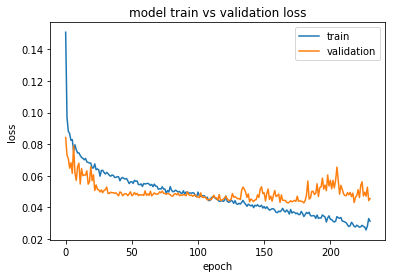

In [29]:
lstm_baseline(X, y_MD, 'MD')

Train on 2072 samples, validate on 518 samples
Epoch 1/500
2072/2072 [==============================] - 5s 2ms/step - loss: 6892.4721 - mean_absolute_error: 80.8255 - val_loss: 4918.9036 - val_mean_absolute_error: 68.3923

Epoch 00001: val_loss improved from inf to 4918.90362, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 2/500
2072/2072 [==============================] - 1s 273us/step - loss: 3353.8375 - mean_absolute_error: 55.3859 - val_loss: 1913.9140 - val_mean_absolute_error: 42.2933

Epoch 00002: val_loss improved from 4918.90362 to 1913.91398, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 3/500
2072/2072 [==============================] - 1s 297us/step - loss: 1219.6763 - mean_absolute_error: 31.6860 - val_loss: 557.0468 - val_mean_absolute_error: 21.7260

Epoch 00003: val_loss improved from 1913.91398 to 557.04684, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 4/500
2072/2072 [==============================] - 1s 298us/step - loss: 555.6224 - mean_absolute_error: 1


Epoch 00033: val_loss did not improve from 24.02073
Epoch 34/500
2072/2072 [==============================] - 1s 398us/step - loss: 162.7292 - mean_absolute_error: 10.0195 - val_loss: 30.8463 - val_mean_absolute_error: 3.9891

Epoch 00034: val_loss did not improve from 24.02073
Epoch 35/500
2072/2072 [==============================] - 1s 407us/step - loss: 179.3469 - mean_absolute_error: 10.4018 - val_loss: 37.1461 - val_mean_absolute_error: 4.4682

Epoch 00035: val_loss did not improve from 24.02073
Epoch 36/500
2072/2072 [==============================] - 1s 381us/step - loss: 175.4121 - mean_absolute_error: 10.4409 - val_loss: 43.8771 - val_mean_absolute_error: 5.1040

Epoch 00036: val_loss did not improve from 24.02073
Epoch 37/500
2072/2072 [==============================] - 1s 369us/step - loss: 168.1858 - mean_absolute_error: 10.2574 - val_loss: 22.3659 - val_mean_absolute_error: 2.6193

Epoch 00037: val_loss improved from 24.02073 to 22.36594, saving model to LSTM_Interval_bes

2072/2072 [==============================] - 1s 363us/step - loss: 167.1173 - mean_absolute_error: 10.3137 - val_loss: 21.0121 - val_mean_absolute_error: 2.6633

Epoch 00069: val_loss did not improve from 20.39895
Epoch 70/500
2072/2072 [==============================] - 1s 357us/step - loss: 168.0135 - mean_absolute_error: 10.2917 - val_loss: 24.4993 - val_mean_absolute_error: 3.1913

Epoch 00070: val_loss did not improve from 20.39895
Epoch 71/500
2072/2072 [==============================] - 1s 349us/step - loss: 167.7005 - mean_absolute_error: 10.3254 - val_loss: 20.8142 - val_mean_absolute_error: 2.4618

Epoch 00071: val_loss did not improve from 20.39895
Epoch 72/500
2072/2072 [==============================] - 1s 388us/step - loss: 169.1152 - mean_absolute_error: 10.2400 - val_loss: 20.3776 - val_mean_absolute_error: 2.4756

Epoch 00072: val_loss improved from 20.39895 to 20.37758, saving model to LSTM_Interval_best_VFI.hdf5
Epoch 73/500
2072/2072 [==============================]

2072/2072 [==============================] - 1s 361us/step - loss: 161.5947 - mean_absolute_error: 9.9516 - val_loss: 22.9169 - val_mean_absolute_error: 3.0366

Epoch 00105: val_loss did not improve from 20.37758
Epoch 106/500
2072/2072 [==============================] - 1s 352us/step - loss: 151.4242 - mean_absolute_error: 9.6707 - val_loss: 23.0008 - val_mean_absolute_error: 2.9503

Epoch 00106: val_loss did not improve from 20.37758
Epoch 107/500
2072/2072 [==============================] - 1s 368us/step - loss: 154.1315 - mean_absolute_error: 9.8056 - val_loss: 32.9556 - val_mean_absolute_error: 4.5935

Epoch 00107: val_loss did not improve from 20.37758
Epoch 108/500
2072/2072 [==============================] - 1s 355us/step - loss: 153.7542 - mean_absolute_error: 9.8184 - val_loss: 24.0664 - val_mean_absolute_error: 3.3378

Epoch 00108: val_loss did not improve from 20.37758
Epoch 109/500
2072/2072 [==============================] - 1s 351us/step - loss: 168.2282 - mean_absolute_


Epoch 00140: val_loss did not improve from 19.14960
Epoch 141/500
2072/2072 [==============================] - 1s 372us/step - loss: 149.8461 - mean_absolute_error: 9.7186 - val_loss: 24.6778 - val_mean_absolute_error: 3.4798

Epoch 00141: val_loss did not improve from 19.14960
Epoch 142/500
2072/2072 [==============================] - 1s 380us/step - loss: 157.8067 - mean_absolute_error: 9.9318 - val_loss: 19.8032 - val_mean_absolute_error: 2.5401

Epoch 00142: val_loss did not improve from 19.14960
Epoch 143/500
2072/2072 [==============================] - 1s 355us/step - loss: 152.7254 - mean_absolute_error: 9.6815 - val_loss: 21.2583 - val_mean_absolute_error: 2.6537

Epoch 00143: val_loss did not improve from 19.14960
Epoch 144/500
2072/2072 [==============================] - 1s 370us/step - loss: 148.8997 - mean_absolute_error: 9.6122 - val_loss: 22.3180 - val_mean_absolute_error: 3.0368

Epoch 00144: val_loss did not improve from 19.14960
Epoch 145/500
2072/2072 [==============

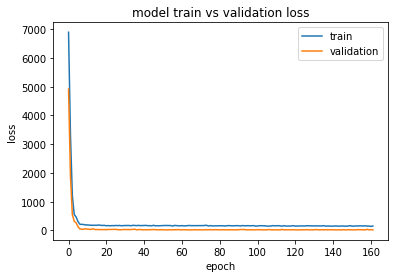

In [30]:
lstm_baseline(X, y_VFI, 'VFI')

Train on 2072 samples, validate on 518 samples
Epoch 1/500
2072/2072 [==============================] - 4s 2ms/step - loss: 3483.8861 - mean_absolute_error: 57.4689 - val_loss: 1721.8671 - val_mean_absolute_error: 40.4807

Epoch 00001: val_loss improved from inf to 1721.86714, saving model to LSTM_Interval_best_GCA.hdf5
Epoch 2/500
2072/2072 [==============================] - 1s 260us/step - loss: 810.1135 - mean_absolute_error: 25.2657 - val_loss: 202.4763 - val_mean_absolute_error: 12.3337

Epoch 00002: val_loss improved from 1721.86714 to 202.47630, saving model to LSTM_Interval_best_GCA.hdf5
Epoch 3/500
2072/2072 [==============================] - 1s 364us/step - loss: 193.8911 - mean_absolute_error: 11.0402 - val_loss: 85.2626 - val_mean_absolute_error: 7.4237

Epoch 00003: val_loss improved from 202.47630 to 85.26255, saving model to LSTM_Interval_best_GCA.hdf5
Epoch 4/500
2072/2072 [==============================] - 1s 361us/step - loss: 176.9658 - mean_absolute_error: 10.5669 -

2072/2072 [==============================] - 1s 389us/step - loss: 78.8663 - mean_absolute_error: 6.9375 - val_loss: 6.3742 - val_mean_absolute_error: 1.7406

Epoch 00070: val_loss did not improve from 4.93592
Epoch 71/500
2072/2072 [==============================] - 1s 389us/step - loss: 80.4579 - mean_absolute_error: 7.0285 - val_loss: 17.8460 - val_mean_absolute_error: 3.6528

Epoch 00071: val_loss did not improve from 4.93592
Epoch 72/500
2072/2072 [==============================] - 1s 368us/step - loss: 77.6753 - mean_absolute_error: 6.9025 - val_loss: 10.0641 - val_mean_absolute_error: 2.5476

Epoch 00072: val_loss did not improve from 4.93592
Epoch 73/500
2072/2072 [==============================] - 1s 383us/step - loss: 76.4629 - mean_absolute_error: 6.8503 - val_loss: 9.2659 - val_mean_absolute_error: 2.3837

Epoch 00073: val_loss did not improve from 4.93592
Epoch 74/500
2072/2072 [==============================] - 1s 398us/step - loss: 74.2058 - mean_absolute_error: 6.8053 -

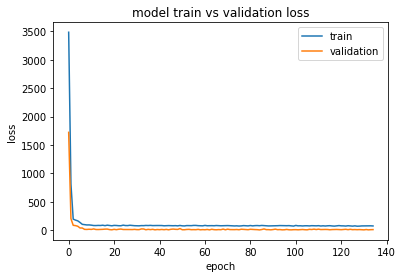

In [31]:
lstm_baseline(X, y_GCA, 'GCA')